In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import pandas as pd
import numpy as np

df_moves = pd.read_csv('/kaggle/input/cheating-tuesdays/moves.csv')

# df_moves = df_moves[df_moves.use].copy().reset_index(drop=True)
df_moves = df_moves.reset_index(drop=True)
df_moves = df_moves.sort_values(by=['game_id', 'move'])

df_players = pd.read_csv('/kaggle/input/cheating-tuesdays/players.csv')
df_analysed_games = pd.read_csv('/kaggle/input/cheating-tuesdays/analysed_games.csv')
df_blocked_users = pd.read_csv('/kaggle/input/cheating-tuesdays/users_who_are_blocked_most_summary.csv')



df_moves

,Best Move,Best Move Eval,Real Move,Ranking Real Move,Real Move Eval,plycount,player,difference,move_timestamp,move_time,...,use,is_top1,is_top3,is_top5,move_timestamp_bin,is_endgame,game_length,pv_rank_top3,pv_rank_top2,pv_rank_top1
0,e2e4,0.38,e2e4,1,0.38,1,white,-0.00,177.3,3.7,...,False,True,True,True,0.1,False,37,1,1,1
1,e7e5,0.23,e7e5,1,0.23,2,black,0.00,176.7,4.3,...,True,True,True,True,0.1,False,37,1,1,1
2,g1f3,0.23,g1f3,1,0.23,3,white,-0.00,177.3,1.0,...,False,True,True,True,0.1,False,37,2,2,2
3,b8c6,0.28,b8c6,1,0.28,4,black,0.00,176.7,1.0,...,True,True,True,True,0.1,False,37,2,2,2
4,f1b5,0.28,f1c4,3,0.17,5,white,0.11,172.7,5.6,...,False,False,True,True,0.2,False,37,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14114898,c1d2,99.00,c1d2,1,99.00,73,white,0.00,61.1,1.2,...,True,True,True,True,2.0,True,39,20,5,3
14114899,h1h2,99.00,h1h2,1,99.00,74,black,0.00,3.7,1.0,...,False,True,True,True,3.0,True,38,4,4,4
14114900,d2e3,99.00,d2c3,2,99.00,75,white,0.00,61.6,0.5,...,True,False,True,True,2.0,True,39,21,6,0
14114901,h2c2,99.00,h2c2,1,99.00,76,black,0.00,3.2,1.5,...,False,True,True,True,3.0,True,38,5,5,5


In [2]:
df_moves.columns

Index(['Best Move', 'Best Move Eval', 'Real Move', 'Ranking Real Move',
       'Real Move Eval', 'plycount', 'player', 'difference', 'move_timestamp',
       'move_time', 'winning_chances', 'winning_chances_before',
       'move_accuracy', 'winning_chances_delta', 'judgement', 'game_id',
       'username', 'move', 'game_result', 'did_flag', 'was_flagged', 'ELO',
       'is_error', 'is_blunder', 'skip', 'use', 'is_top1', 'is_top3',
       'is_top5', 'move_timestamp_bin', 'is_endgame', 'game_length',
       'pv_rank_top3', 'pv_rank_top2', 'pv_rank_top1'],
      dtype='object')

### **Разница в оценке движка между ходами**

In [3]:
df_moves['positions_difference'] = df_moves.groupby('game_id')['Real Move Eval'].diff()
df_moves['deviation'] = (df_moves.positions_difference - df_moves.positions_difference.mean())/df_moves.positions_difference.std()
df_moves['susp'] = 0 
df_moves.loc[((df_moves['deviation']>3) | (df_moves['deviation']<-3)), 'susp'] = 1
df_susp_moves = df_moves[df_moves.susp == 1]
df_normal_moves = df_moves[df_moves.susp == 0]
print(f'Количество подозрительных ходов - {len(df_susp_moves)}, кол-во обычных - {len(df_normal_moves)}')

print(f'Частота подозрительных ходов - {len(df_susp_moves)/len(df_moves):.4f}')


Количество подозрительных ходов - 179626, кол-во обычных - 13935277
Частота подозрительных ходов - 0.0127


### Список всех партий, в которых были аномальные скачки в оценке ("подозрительные" ходы)

In [4]:
susp_games = df_susp_moves.game_id.unique()
print(f'Количество партий с подозрительными ходами - {len(susp_games)}')

Количество партий с подозрительными ходами - 77763


# **Графики**

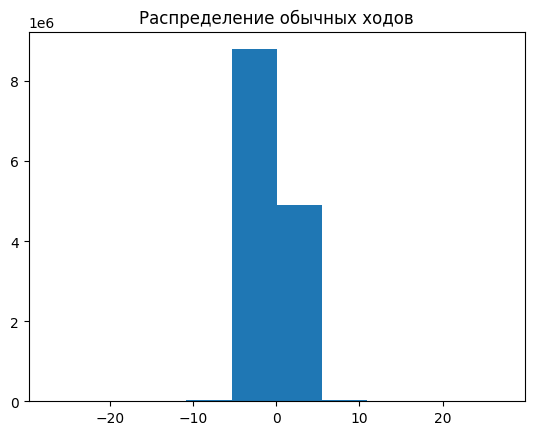

In [5]:
plt.hist(df_normal_moves.positions_difference)
plt.title('Распределение обычных ходов')
plt.show()

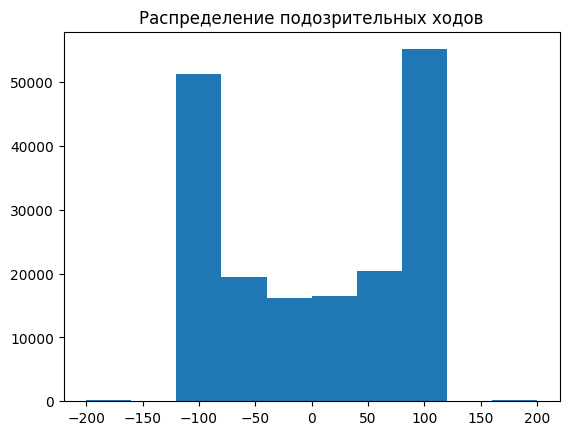

In [6]:
plt.hist(df_susp_moves.positions_difference)
plt.title('Распределение подозрительных ходов')
plt.show()

#### Отрисовка случайных партий с аномальными скачками

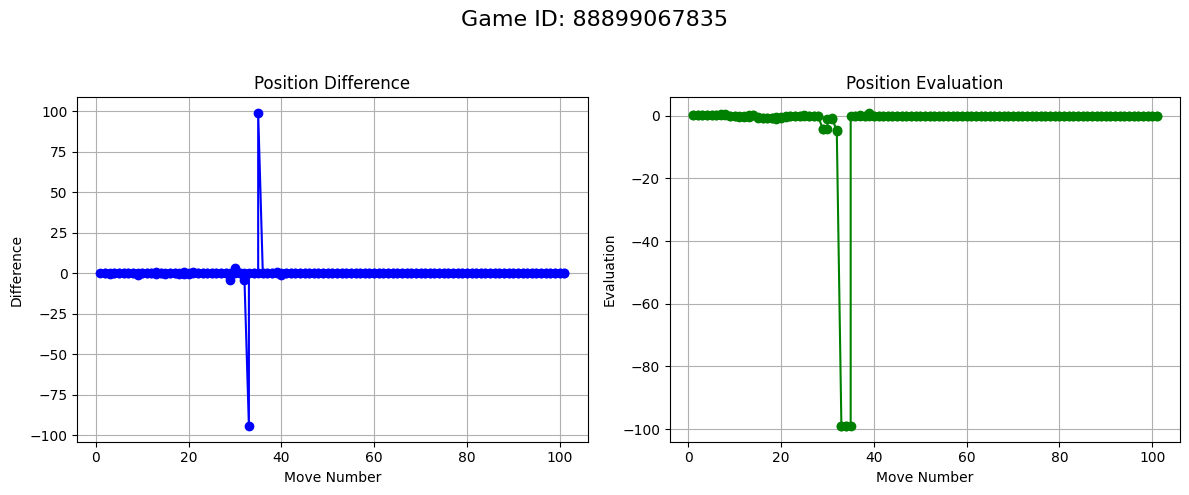

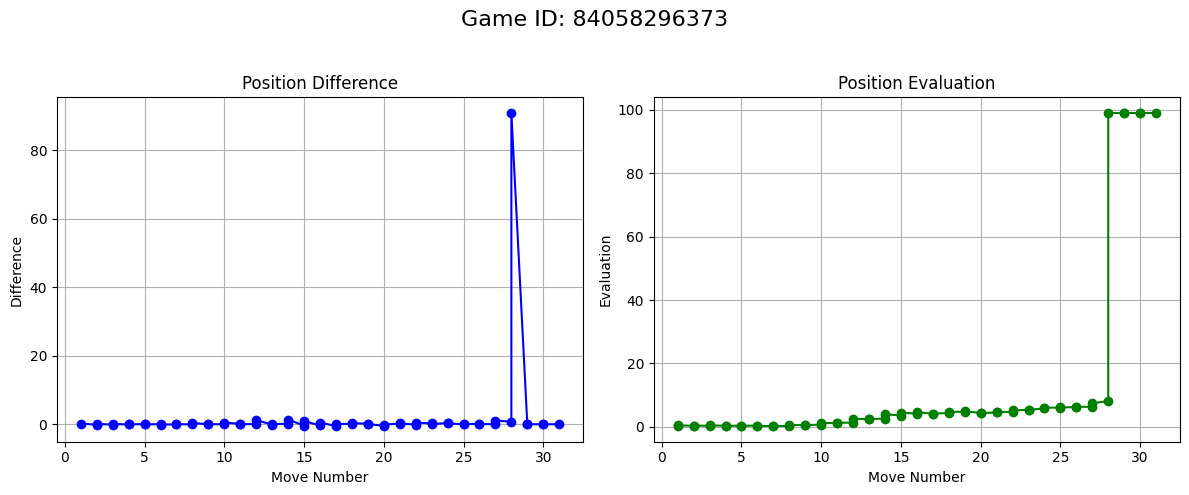

In [7]:
import random
selected_games = random.sample(list(susp_games), 2)


def plot_game(df_moves, game_id):
    game_data = df_moves[df_moves['game_id'] == game_id]

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # График 1: Номер хода - Изменение в позиции (positions_difference)
    axes[0].plot(game_data['move'], game_data['positions_difference'], marker='o', color='blue')
    axes[0].set_title('Position Difference')
    axes[0].set_xlabel('Move Number')
    axes[0].set_ylabel('Difference')
    axes[0].grid(True)

    # График 2: Номер хода - Оценка позиции (evaluation)
    axes[1].plot(game_data['move'], game_data['Real Move Eval'], marker='o', color='green')
    axes[1].set_title('Position Evaluation')
    axes[1].set_xlabel('Move Number')
    axes[1].set_ylabel('Evaluation')
    axes[1].grid(True)

    # Общий заголовок для всей фигуры
    plt.suptitle(f'Game ID: {game_id}', fontsize=16)
    
    # Отобразить графики
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Слегка подвинуть графики, чтобы заголовок не пересекался
    plt.show()

# Для каждой выбранной партии строим два графика
for game_id in selected_games:
    plot_game(df_moves, game_id)


## Посмотрим как зависят оценка позиции в среднем по игрокам разных ЭЛО

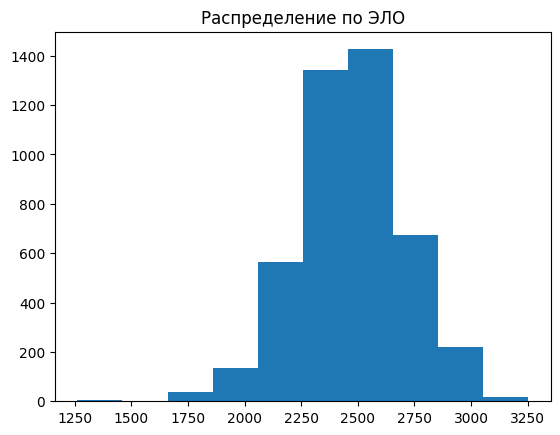

In [8]:
plt.hist(df_players.averageElo)
plt.title('Распределение по ЭЛО')
plt.show()

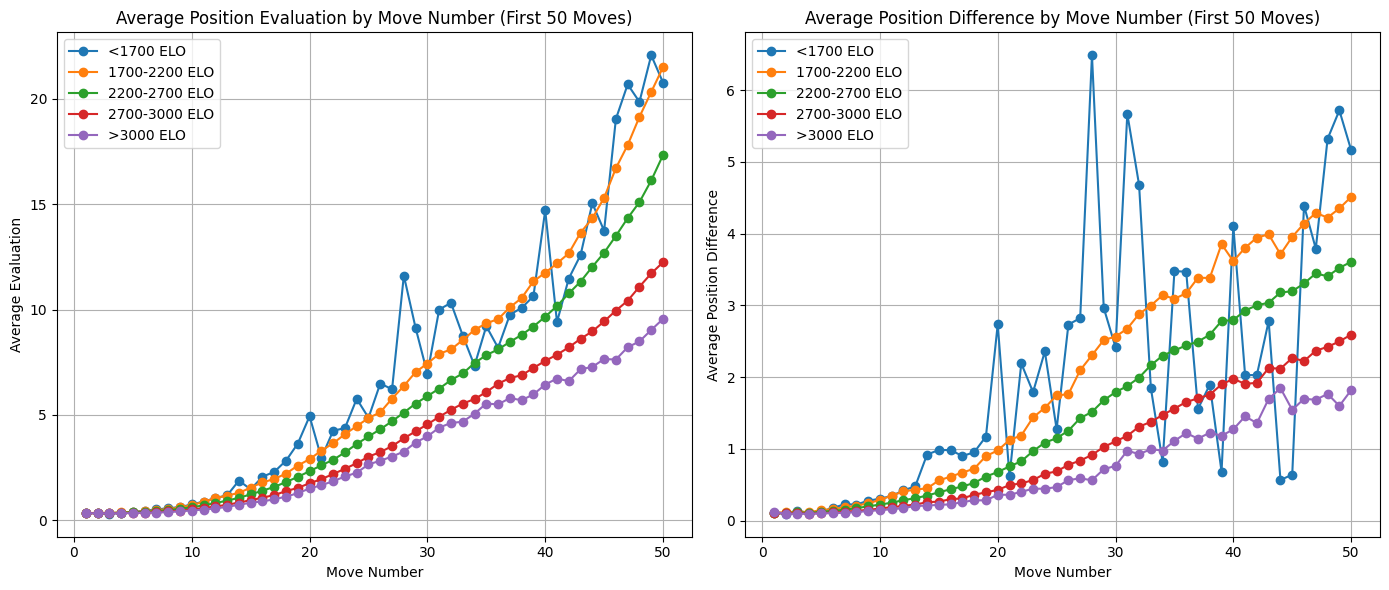

In [9]:
import warnings
# Скрыть предупреждения
warnings.filterwarnings("ignore", category=FutureWarning)

# Функция для построения графиков
def plot_average_evaluation_and_difference(df_moves):
    # Разделяем данные по уровням ELO
    elo_bins = ['<1700 ELO', '1700-2200 ELO', '2200-2700 ELO', '2700-3000 ELO', '>3000 ELO']
    conditions = [
        (df_moves['ELO'] < 1700),
        (df_moves['ELO'] >= 1700) & (df_moves['ELO'] < 2200),
        (df_moves['ELO'] >= 2200) & (df_moves['ELO']<2700),
        (df_moves['ELO'] >=2700) & (df_moves['ELO']<3000),
        (df_moves['ELO'] > 3000)
    ]
    df_moves['ELO_Level'] = pd.cut(df_moves['ELO'], bins=[-float('inf'), 1700, 2200, 2700, 3000, float('inf')],
                                   labels=elo_bins)

    # Фильтруем данные только для первых 50 ходов
    df_moves_filtered = df_moves[df_moves['move'] <= 50]

    avg_eval = df_moves_filtered.groupby(['ELO_Level', 'move'], observed=True)['Real Move Eval'].apply(lambda x: x.abs().mean()).reset_index()
    avg_diff = df_moves_filtered.groupby(['ELO_Level', 'move'], observed=True)['positions_difference'].apply(lambda x: x.abs().mean()).reset_index()


    # Построение графика для усреднённой оценки позиции
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    
    for elo_level in elo_bins:
        subset = avg_eval[avg_eval['ELO_Level'] == elo_level]
        plt.plot(subset['move'], subset['Real Move Eval'], marker='o', label=elo_level)
    plt.title('Average Position Evaluation by Move Number (First 50 Moves)')
    plt.xlabel('Move Number')
    plt.ylabel('Average Evaluation')
    plt.grid(True)
    plt.legend()

    # Построение графика для усреднённой разницы между ходами
    plt.subplot(1, 2, 2)
    for elo_level in elo_bins:
        subset = avg_diff[avg_diff['ELO_Level'] == elo_level]
        plt.plot(subset['move'], subset['positions_difference'], marker='o', label=elo_level)
    plt.title('Average Position Difference by Move Number (First 50 Moves)')
    plt.xlabel('Move Number')
    plt.ylabel('Average Position Difference')
    plt.grid(True)
    plt.legend()

    # Отобразить оба графика
    plt.tight_layout()
    plt.show()

# Вызов функции для отображения графиков
plot_average_evaluation_and_difference(df_moves)


#### По графикам можно сделать вывод, что чем ниже ЭЛО у игроков, тем нестабильнее они играют (выше среднее скачки между ходами)
#### А также, что чем дальше идёт игра, разница между оценками позиций тоже растёт

## **Сбор признаков**

### В своей модели классификации я буду использовать следующие признаки:
- Оценку текущего и двух предыдущих ходов партии
- Время, за которое сделан ход
- Точность хода по оценке движка
- Разница в вероятности победы игрока после сделанного хода
- Сделан ли ход по первой, третьей или пятой линии
- Является ли ход ошибкой или зевком
- Номер хода в партии
- Сделан ли ход в эндгейме или нет
- ЭЛО игрока, делающего ход
- Коэффициент того, насколько часто игрока блокируют другие игроки
- Проиграл игрок, делающий ход, или нет

In [14]:
# Соединение таблиц df_moves и df_blocked_players по 'username' с использованием left join
df_moves = pd.merge(df_moves, df_blocked_users[['username', 'was_blocked_to_played_player_ratio']], 
                     how='left', on='username')

# Заполнение пропущенных значений в столбце was_blocked_to_played_player_ratio нулями для тех, кто отсутствует в df_blocked_players
df_moves['block_ratio'] = df_moves['was_blocked_to_played_player_ratio'].fillna(0)


X = df_moves[['Real Move Eval', 'move_time', 'move_accuracy', 'winning_chances_delta', 'is_top1', 'is_top3', 'is_top5',
        'is_error', 'is_blunder', 'move', 'is_endgame', 'ELO', 'game_result', 'block_ratio']]

df_moves = df_moves.drop(columns = ['was_blocked_to_played_player_ratio', 'block_ratio'])

from_bool_to_int = ['is_top1', 'is_top3', 'is_top5', 'is_error', 'is_blunder']
X.loc[:, from_bool_to_int] = X[from_bool_to_int].astype(int)

X = X.rename(columns = {'Real Move Eval': 'eval', 'move_time': 'time', 'move':'cnt', 'winning_chances_delta':'delta', 
                        'move_accuracy':'acc', 'game_result':'result'})

X['eval log1'] = X['eval'].shift(1, fill_value=0)
X['eval log2'] = X['eval'].shift(2, fill_value=0)
X.loc[X['cnt']==1, ['eval log1', 'eval log2']] = 0 #Заполняю нулём "предыдущие" хода для первых ходов

y = df_moves['susp']


from sklearn.preprocessing import StandardScaler
#Заранее определим функцию, чтобы использовать для линейных алгоритмов
def standardize_columns(df, columns):
    """
    Нормализует числовые значения в указанных столбцах датафрейма с использованием StandardScaler.
    
    Параметры:
    df (pd.DataFrame): Исходный датафрейм.
    columns (list): Список столбцов для стандартизации.
    
    Возвращает:
    pd.DataFrame: Датафрейм с нормализованными значениями в указанных столбцах.
    """
    scaler = StandardScaler()
    
    # Применяем стандартизацию только к указанным столбцам
    df[columns] = scaler.fit_transform(df[columns])
    
    return df

X = standardize_columns(X, ['eval', 'acc', 'time', 'cnt', 'ELO', 'eval log1', 'eval log2'])


In [15]:
X

,eval,time,acc,delta,is_top1,is_top3,is_top5,is_error,is_blunder,cnt,is_endgame,ELO,result,block_ratio,eval log1,eval log2
0,-0.005853,-0.095815,0.537388,0.069846,1,1,1,0,0,-1.331726,False,-0.137672,0.0,0.008696,-0.023370,-0.023048
1,-0.012999,-0.005343,0.537388,0.027527,1,1,1,0,0,-1.331726,False,2.754967,1.0,0.003731,-0.023370,-0.023048
2,-0.012999,-0.502939,0.537381,0.000000,1,1,1,0,0,-1.278746,False,-0.137672,0.0,0.008696,-0.011800,-0.002699
3,-0.010617,-0.502939,0.395524,-0.009185,1,1,1,0,0,-1.278746,False,2.754967,1.0,0.003731,-0.011800,-0.010731
4,-0.015857,0.190680,0.228857,-0.020216,0,1,1,0,0,-1.225766,False,-0.137672,0.0,0.008696,-0.009285,-0.010731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14114898,4.692408,-0.472782,0.537381,0.000000,1,1,1,0,0,0.575558,True,-2.230654,1.0,0.000000,4.956938,5.278595
14114899,4.692408,-0.502939,0.537381,0.000000,1,1,1,0,0,0.575558,True,-2.720240,0.0,0.000000,4.956938,5.278595
14114900,4.692408,-0.578332,0.537381,0.000000,0,1,1,0,0,0.628538,True,-2.230654,1.0,0.000000,4.956938,5.278595
14114901,4.692408,-0.427546,0.537381,0.000000,1,1,1,0,0,0.628538,True,-2.720240,0.0,0.000000,4.956938,5.278595


# **Модель классификации**

### Проблема с которой нужно считатья - дисбаланс классов.
### У нас 1.27% объектов в выборке класса 1 (подозрительные ходы), остальные с классом 0

In [16]:
from sklearn.model_selection import train_test_split

# Стратифицированное разбиение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [17]:
#Удалим ненужные переменные из памяти
del df_moves
del X
import gc
gc.collect()

33693

## Основной метрикой для данной задачи я выберу **f1 score**
Потому что в задаче нам одинаково важны **precision** (среди всех засчитанных моделью подозрительных партий, сколько настоящих?) и **recall** (среди всех подозрительных ходов сколько модель детектит?)

Для работы с несбалансированным датасетом я применю метод **Undersampling**, поскольку датасет огромный и не так страшно потерять данные для обучения.

In [27]:
from imblearn.under_sampling import RandomUnderSampler

# Создаем экземпляр RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Применяем undersampling к данным
X_train, y_train = rus.fit_resample(X_train, y_train)


print("Распределение классов после undersampling:", dict(zip(*np.unique(y_train, return_counts=True))))
print("Распределение классов в test: ", dict(zip(*np.unique(y_test, return_counts=True))))

Распределение классов после undersampling: {0: 143701, 1: 143701}
Распределение классов в test:  {0: 2787056, 1: 35925}


In [28]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import make_scorer, f1_score

# Создаем список моделей для оценки
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced',max_iter=500, random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced',max_depth=10, n_estimators=10, random_state=42),
    'SVC': SVC(class_weight='balanced', max_iter=500, random_state=42),
    'XGBoost': XGBClassifier(scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), random_state=42),
    'LightGBM': LGBMClassifier(scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), random_state=42)
}

# Создаем стратифицированную кросс-валидацию
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Используем F1-score в качестве метрики
f1_scorer = make_scorer(f1_score)

# Для хранения результатов
model_scores = {}

# Проходим по каждой модели и вычисляем средний F1-score
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring=f1_scorer)
    model_scores[name] = scores.mean()
    print(f'{name} F1-score: {scores.mean():.4f}')

# Находим лучшую модель
best_model_name = max(model_scores, key=model_scores.get)
best_f1_score = model_scores[best_model_name]

print(f'\nЛучшая модель: {best_model_name} с F1-score: {best_f1_score:.4f}')


Logistic Regression F1-score: 0.8230
Random Forest F1-score: 0.9952


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-

SVC F1-score: 0.8749
XGBoost F1-score: 0.9992
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 114961, number of negative: 114960
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2210
[LightGBM] [Info] Number of data points in the train set: 229921, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000009
[LightGBM] [Info] Start training from score 0.000009
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 114960, number of negative: 114961
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050333 seconds.
You can set `force_row_wise=true` to remove the overhead.


In [31]:
rf = LGBMClassifier(random_state = 42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f1_score(y_test, y_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 143701, number of negative: 143701
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2209
[LightGBM] [Info] Number of data points in the train set: 287402, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
0.958992978615479


In [32]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")


Precision: 0.92
Recall: 1.00


# Данные результаты показывают, что модели удалось детектировать 100% подозрительных ходов на тестовых данных, при этом не так много (лишь 8%) обычных ходов модель отметила как подозрительные